Convert and Optimize YOLOv8 with OpenVINO™

The YOLOv8 algorithm is developed by Ultralytics, is a cutting-edge, state-of-the-art (SOTA) model that is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection, image segmentation and image classification tasks.

YOLO stands for “You Only Look Once”, it is a popular family of real-time object detection algorithms. 
The original YOLO object detector was first released in 2016. Since then, different versions and variants of YOLO have been proposed, each providing a significant increase in performance and efficiency.
YOLOv8 builds upon the success of previous YOLO versions and introduces new features and improvements to further boost performance and flexibility.
More details about its realization can be found in original model [repository](https://github.com/ultralytics/ultralytics)

Real-time object detection is often used as a key component in computer vision systems. 
Applications that use real-time object detection models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.


This tutorial demonstrates step-by-step instructions on how to run and optimize PyTorch\* Yolo V8 with OpenVINO.

The tutorial consists of the following steps:
- Prepare PyTorch model
- Download and prepare dataset
- Validate original model
- Convert PyTorch model to OpenVINO IR
- Validate converted model
- Prepare and run optimization pipeline
- Compare accuracy of the FP32 and quantized models.
- Compare performance of the FP32 and quantized models.

## Get Pytorch model

Generally, PyTorch models represent an instance of the [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv8 nano model (also known as `yolov8n`) pretrained on COCO dataset, which available in this [repo](https://github.com/ultralytics/ultralytics). The similar steps are also applicable to other YOLOv8 models.
Typical steps to obtain pretrained model:
1. Create instance of model class
2. Load checkpoint state dict, which contains pretrained model weights
3. Turn model to evaluation for switching some operations to inference mode

In this case, the model creators provide a API that enables converting the YOLOv8 model to ONNX and then to OpenVINO IR, so we don't need to do these steps manually.

### Prerequisites

Install necessary packages.

In [ ]:
!pip install ultralytics

In [2]:
try:
    import nncf  # noqa: F401
except ImportError:
    !pip install "git+https://github.com/openvinotoolkit/nncf.git#egg=nncf"

/home/ea/work/notebooks_env/lib/python3.8/site-packages/openvino/offline_transformations/__init__.py:10: FutureWarning: The module is private and following namespace `offline_transformations` will be removed in the future, use `openvino.runtime.passes` instead!
  warnings.warn(


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


This notebook based on yolov8n pretrained on 

In [3]:
from ultralytics import YOLO

MODEL_NAME = "yolov8n"

model = YOLO(f'{MODEL_NAME}.pt')

In [4]:
label_map = model.model.names

In [5]:
IMAGE_PATH = "../data/image/coco_bike.jpg"
results = model(IMAGE_PATH)

Ultralytics YOLOv8.0.4 🚀 Python-3.8.10 torch-1.13.1+cpu CPU
Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


In [6]:
image_res = next(results)['det']

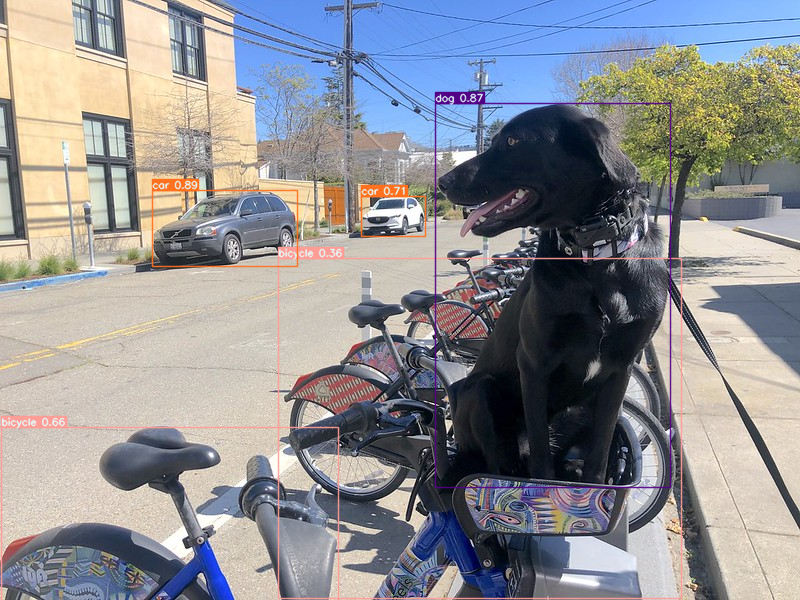

In [7]:
import cv2
import numpy as np
from PIL import Image
from ultralytics.yolo.utils.plotting import colors


def plot_one_box(box, img, color=None, label=None, line_thickness=5):
    """
    Helper function for drawing bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowin resul
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    return img


def draw_boxes(image_res, source_image):
    for *xyxy, conf, cls in reversed(image_res):
        label = f'{label_map[int(cls)]} {conf:.2f}'
        source_image = plot_one_box(xyxy, source_image, label=label, color=colors(int(cls)), line_thickness=1)
    return source_image


img = np.array(Image.open(IMAGE_PATH))
img_with_boxes = draw_boxes(image_res, img.copy())
Image.fromarray(img_with_boxes)

## Convert model to OpenVINO IR

YOLOv8 provides API for convinient model exporting to different formats including OpenVINO
`model.export` is responsible for model conversion. We need to specify format and additionally we can preserve dynamic shapes in model.

In [8]:
from pathlib import Path

model_path = Path(f"{MODEL_NAME}_openvino_model/{MODEL_NAME}.xml")
if not model_path.exists():
    model.export(format="openvino", dynamic=True, half=False)

## Verify model inference

To test model work, we create inference pipeline similar to `model.predict` method. Our pipeline consists from preprocessing step, inference of OpenVINO model and results post-processing to get bounding boxes.

In [9]:
from openvino.runtime import Core

core = Core()
ov_model = core.read_model(model_path)
compiled_model = core.compile_model(ov_model)

### Preprocessing

Model input is tensor with shape `[-1, 3, -1, -1]` in `N, C, H, W` format, where
* `N` - number of images in batch (batch size)
* `C` - image channels
* `H` - image height
* `W` - image width

Model expects images in RGB channels format and normalized in [0, 1] range. However model support dynamic input shape with preserving input divisibility to 32, it is recommended to use static shapes e.g. 640x640 for better efficiency
To resize images to fit model size `letterbox` resize approach is used where the aspect ratio of width and height is preserved.

To keep specific shape preprocessing automatically enables padding.

In [10]:
from typing import Tuple
from ultralytics.yolo.utils import ops
import torch
import numpy as np


def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (640, 640), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    """
    Resize image and padding for detection. Takes image as input, 
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints
    
    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size
    
    
    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
    """
    # resize
    img = letterbox(img0)[0]
    
    # Convert HWC to CHW
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def image_to_tensor(image:np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img (np.ndarray): image for preprocessing
    Returns:
      input_tensor (np.ndarray): input tensor in NCHW format with float32 values in [0, 1] range 
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

### Postprocessing

Model output contains detection boxes candidates, it is a tensor with shape `[-1,84,-1]` in format `B,84,N` where:

- `B` - batch size
- `N` - number of detection boxes

Detection box has format [`x`, `y`, `h`, `w`, `class_no_1`, ..., `class_no_80`], where:

- (`x`, `y`) - raw coordinates of box center
- `h`, `w` - raw height and width of box
- `class_no_1`, ..., `class_no_80` - probability distribution over the classes.

For getting final prediction, we need to apply non maximum supression algorithm and rescale boxes coordinates to original image size.

In [11]:
def postprocess(preds:np.ndarray, img:np.ndarray, orig_img:np.ndarray, min_conf_threshold:float = 0.25, nms_iou_threshold:float = 0.7, agnosting_nms:bool = False, max_detections:int = 300):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        preds (np.ndarray): model output predictions
        img (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accpeted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for remloving objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
    Returns:
       pred (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    
    preds = ops.non_max_suppression(
        torch.from_numpy(preds),
        min_conf_threshold,
        nms_iou_threshold,
        agnostic=agnosting_nms,
        max_det=max_detections
    )

    for i, pred in enumerate(preds):
        shape = orig_img.shape
        pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], shape).round()

    return preds

### Test on single image

Now, when we defined preprocessing and postprocessing steps, we are ready to check model prediction

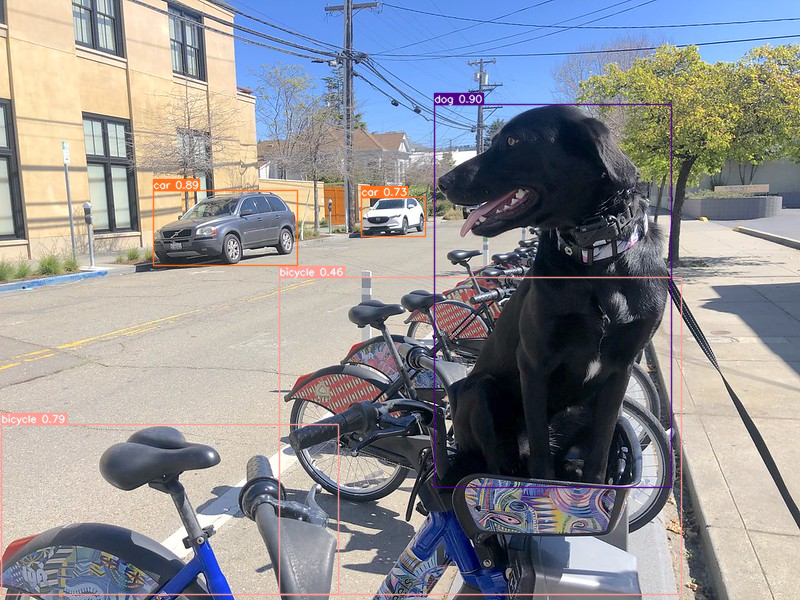

In [12]:
def detect(image, model):
    """
    OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    output_layer = model.output(0)
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    result = model(input_tensor)[output_layer]
    detections = postprocess(result, input_tensor, image)
    return detections


input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, compiled_model)[0]
image_with_boxes = draw_boxes(detections, input_image)

Image.fromarray(image_with_boxes)

## Check model accuracy on dataset

For comparing optimized model result with original, it is good to know some measurable results in termins of model accuracy on validation dataset. 


### Download validation dataset

YOLOv8 is pre-trained on the COCO dataset, so in order to evaluate the model accuracy we need to download it. According to the instructions provided in the YOLOv8 repo, we also need to download annotations in the format used by the model author for use with the original model evaluation scripts.


In [13]:
import sys
from zipfile import ZipFile

sys.path.append("../utils")
from notebook_utils import download_file

DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"

OUT_DIR = Path('./datasets')

download_file(DATA_URL, directory=OUT_DIR, show_progress=True)
download_file(LABELS_URL, directory=OUT_DIR, show_progress=True)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile(OUT_DIR / 'coco2017labels-segments.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile(OUT_DIR / 'val2017.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

'datasets/val2017.zip' already exists.
'datasets/coco2017labels-segments.zip' already exists.


### Configure DetectionValidator helper and create DataLoader

Original model repository uses `DetectionValidator` wrapper, which represents accuracy validation pipeline. It creates dataloader and evaluation metrics and update metrics on each data batch produced by dataloader. Beside that it responsible for data preprocessing and results postprocessing. For class intialization configaration should be provided. We will use default setup, but it can be replaced with some parameters overriding to test on custom data.  

In [14]:
from ultralytics.yolo.utils import DEFAULT_CONFIG
from ultralytics.yolo.configs import get_config
args = get_config(config=DEFAULT_CONFIG)
args.data = "coco.yml"

In [15]:
validator = model.ValidatorClass(args)

In [ ]:
data_loader = validator.get_dataloader("datasets/coco", 1)

In [17]:
from tqdm.notebook import tqdm
from ultralytics.yolo.utils.metrics import ConfusionMatrix

validator.is_coco = True
validator.class_map = ops.coco80_to_coco91_class()
validator.names = model.model.names
validator.metrics.names = validator.names
validator.nc = model.model.model[-1].nc

### Define validation function

In [18]:
def test(compiled_model, data_loader, num_samples=None):
    """
    OpenVINO YOLOv8 model accuracy validation function. Runs model validation on dataset and returns metrics
    Parameters:
        compiled_model (Model): OpenVINO compiled model
        data_loater (torch.utils.data.DataLoader): dataset loader
        num_samples (int, *optional*, None): validate model only on specified number samples, if provided
    Returns:
        stats: (Dict[str, float]) - dictionary with agragated accuracy metrics statistics, key is metric name, value is metric value
    """
    validator.seen = 0
    validator.jdict = []
    validator.stats = []
    validator.confusion_matrix = ConfusionMatrix(nc=validator.nc)
    output_layer = compiled_model.output(0)
    for batch_i, batch in enumerate(data_loader):
        if num_samples is not None and batch_i == num_samples:
            break
        batch = validator.preprocess(batch)
        preds = torch.from_numpy(compiled_model(batch["img"])[output_layer])
        preds = validator.postprocess(preds)
        validator.update_metrics(preds, batch)
    stats = validator.get_stats()
    return stats


def print_stats(stats, total_images, total_objects):
    """
    Helper function for printing accuracy statistic
    Parameters:
        stats: (Dict[str, float]) - dictionary with agragated accuracy metrics statistics, key is metric name, value is metric value
        total_images (int) -  number of evaluated images
        total objects (int)
    Returns:
        None
    """
    mp, mr, map50, mean_ap = stats['metrics/precision(B)'], stats['metrics/recall(B)'], stats['metrics/mAP50(B)'], stats['metrics/mAP50-95(B)']
    # Print results
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
    print(s)
    pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
    print(pf % ('all', total_images, total_objects, mp, mr, map50, mean_ap))

In [ ]:
compiled_model = core.compile_model(ov_model)
fp_stats = test(compiled_model, tqdm(data_loader))
fp_confusion_matrix = validator.confusion_matrix
fp_confusion_matrix.plot(save_dir=model_path.parent, names=list(label_map.values()))

In [32]:
print_stats(fp_stats, validator.seen, validator.nt_per_class.sum())

               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335       0.633       0.474       0.521       0.371


`print_stats` reports following list of accuracy metrics:

* `Precision` is the degree of exactness of the model in identifying only relevant objects. 
* `Recall` measures the ability of the model to detect all ground truths objects.
* `mAP@t` - mean average precision, represented as area under the Precision-Recall curve agregated over all classes in dataset,  where `t` is Intersection Over Union (IOU) threshold, degree of overlaping between ground truth and predicted objects.
            So, `mAP@.5` means that mean average precision calculated at 0.5 IOU threshold, `mAP@.5:.95` - calculated on range IOU threshlods from 0.5 to 0.95 with step 0.05.

We also can visualize confusion matrix. A confusion matrix is a table showing the accuracy of a classifier given some truth values/instances (supervised learning kind of). For object detection task, this metric shows how good predicted objects labels matched with represented in annotation based on Intersection over Union (IOU) of their coordinates.

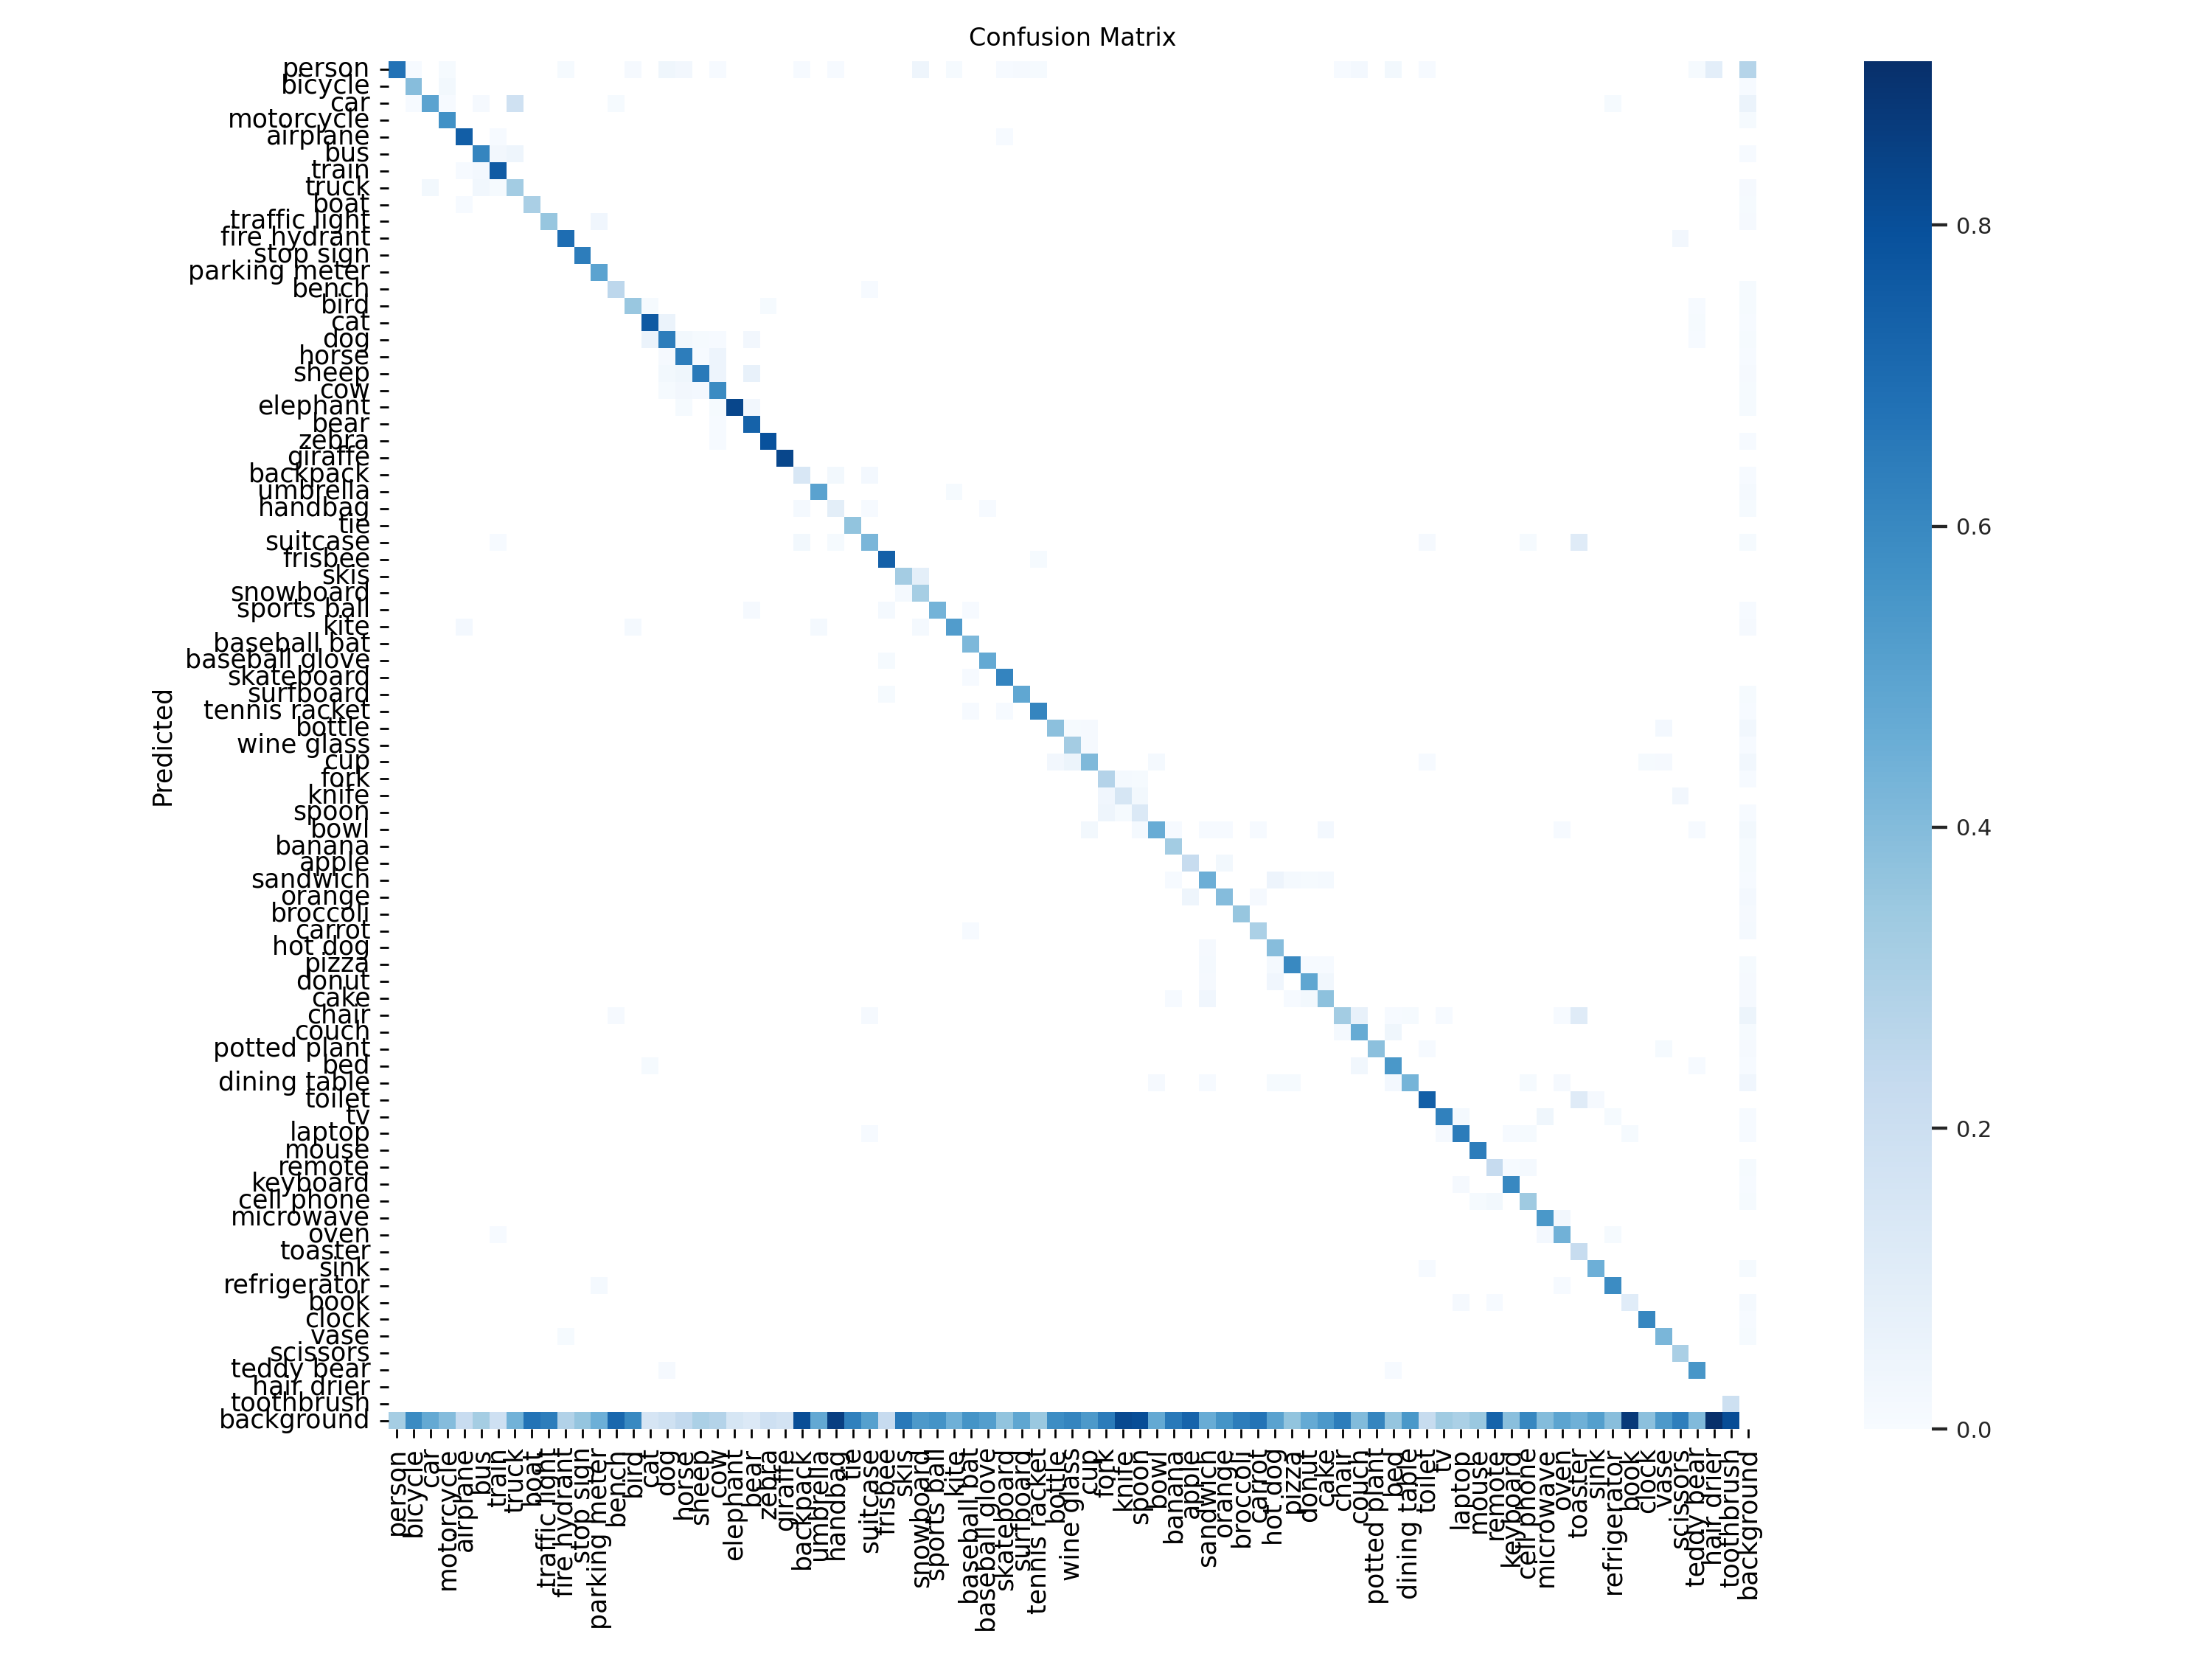

In [33]:
from IPython.display import Image as display_image
display_image(model_path.parent / "confusion_matrix.png", width=600, height=600)

## Optimize model using NNCF Post-training Quantization API

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv7.

> **Note**: NNCF Post-training Quantization is available as a preview feature in OpenVINO 2022.3 release.
Fully functional support will be provided in the next releases.

The optimization process contains the following steps:

1. Create Dataset for quantization
2. Run `nncf.quantize` for getting optimized model
3. Serialize OpenVINO IR model using `openvino.runtime.serialize` function

Reuse validation dataloader in accuracy testing for quantization. 
For that, it should be wrapped into the `nncf.Dataset` object and define transformation function for getting only input tensors.

In [21]:
import nncf  # noqa: F811


def transform_fn(data_item):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = validator.preprocess(data_item)['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(data_loader, transform_fn)

`nncf.quantize` function provides interface for model quantization. It requires instance of OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for configuration quantization process (number of samples for quantization, preset, ignored scope etc.) can be provided.
YOLOv8 model contains non-ReLU activation functions, which require asymmetric quantization of activations. To achive better result we will use `mixed` quantization preset.
It provides symmetric quantization of weights and asymmetric quantization of activations. For more accurate result we should stay operation in postprocessing subgraph to floating point precision using `ignored_scope` parameter. 

In [22]:
quantized_model = nncf.quantize(
    ov_model, 
    quantization_dataset,
    preset=nncf.QuantizationPreset.MIXED,
    ignored_scope=nncf.IgnoredScope(
        types=["Multiply", "Subtract", "Add", "Sigmoid"],
        names=["/model.22/dfl/conv/Conv"]
    ))

INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.pipeline.pipeline:Model Optimizer version:                 2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.pipeline.pipeline:Post-Training Optimization Tool version: 2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.statistics.collector:Start computing statistics for algorithms : DefaultQuantization
INFO:openvino.tools.pot.statistics.collector:Computing statistics finished
INFO:openvino.tools.pot.pipeline.pipeline:Start algorithm: DefaultQuantization
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithm : ActivationChannelAlignment
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Computing statistics finished
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithms : MinMaxQuantization,F

In [23]:
from openvino.runtime import serialize
int8_model_path = Path(f'{MODEL_NAME}_openvino_int8_model/{MODEL_NAME}.xml')
print(f"Quantized model will be saved to {int8_model_path}")
serialize(quantized_model, str(int8_model_path))

Quantized model will be saved to yolov8n_openvino_int8_model/yolov8n.xml


## Validate Quantized model inference

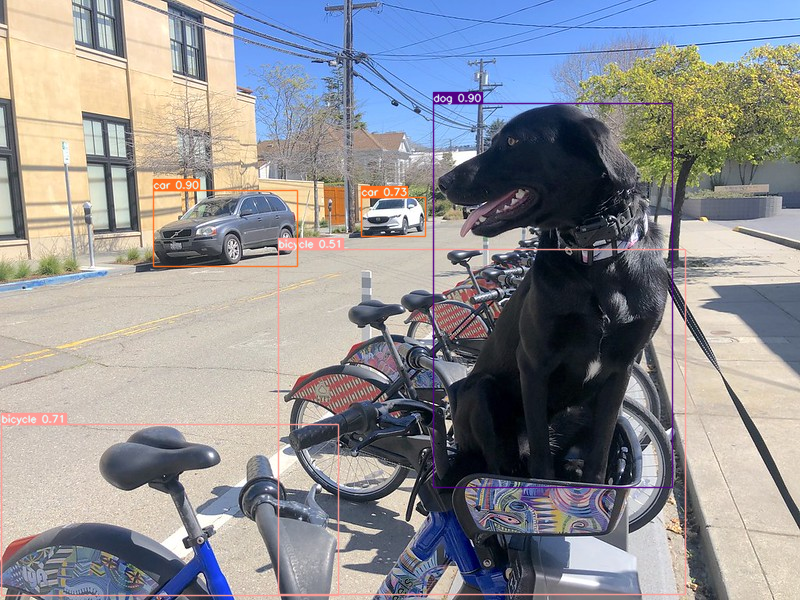

In [24]:
quantized_compiled_model = core.compile_model(quantized_model)
input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, quantized_compiled_model)[0]
image_with_boxes = draw_boxes(detections, input_image)

Image.fromarray(image_with_boxes)

## Validate quantized model accuracy

In [ ]:
compiled_model = core.compile_model(quantized_model)
int8_stats = test(compiled_model, tqdm(data_loader))
confusion_matrix = validator.confusion_matrix
confusion_matrix.plot(save_dir=int8_model_path.parent, names=list(label_map.values()))

In [26]:
print("FP32 model accuracy")
print_stats(fp_stats, validator.seen, validator.nt_per_class.sum())

print("INT8 model accuracy")
print_stats(fp_stats, validator.seen, validator.nt_per_class.sum())

FP32 model accuracy
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335       0.633       0.474       0.521       0.371
INT8 model accuracy
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335       0.633       0.474       0.521       0.371


FP32 confusion matrix


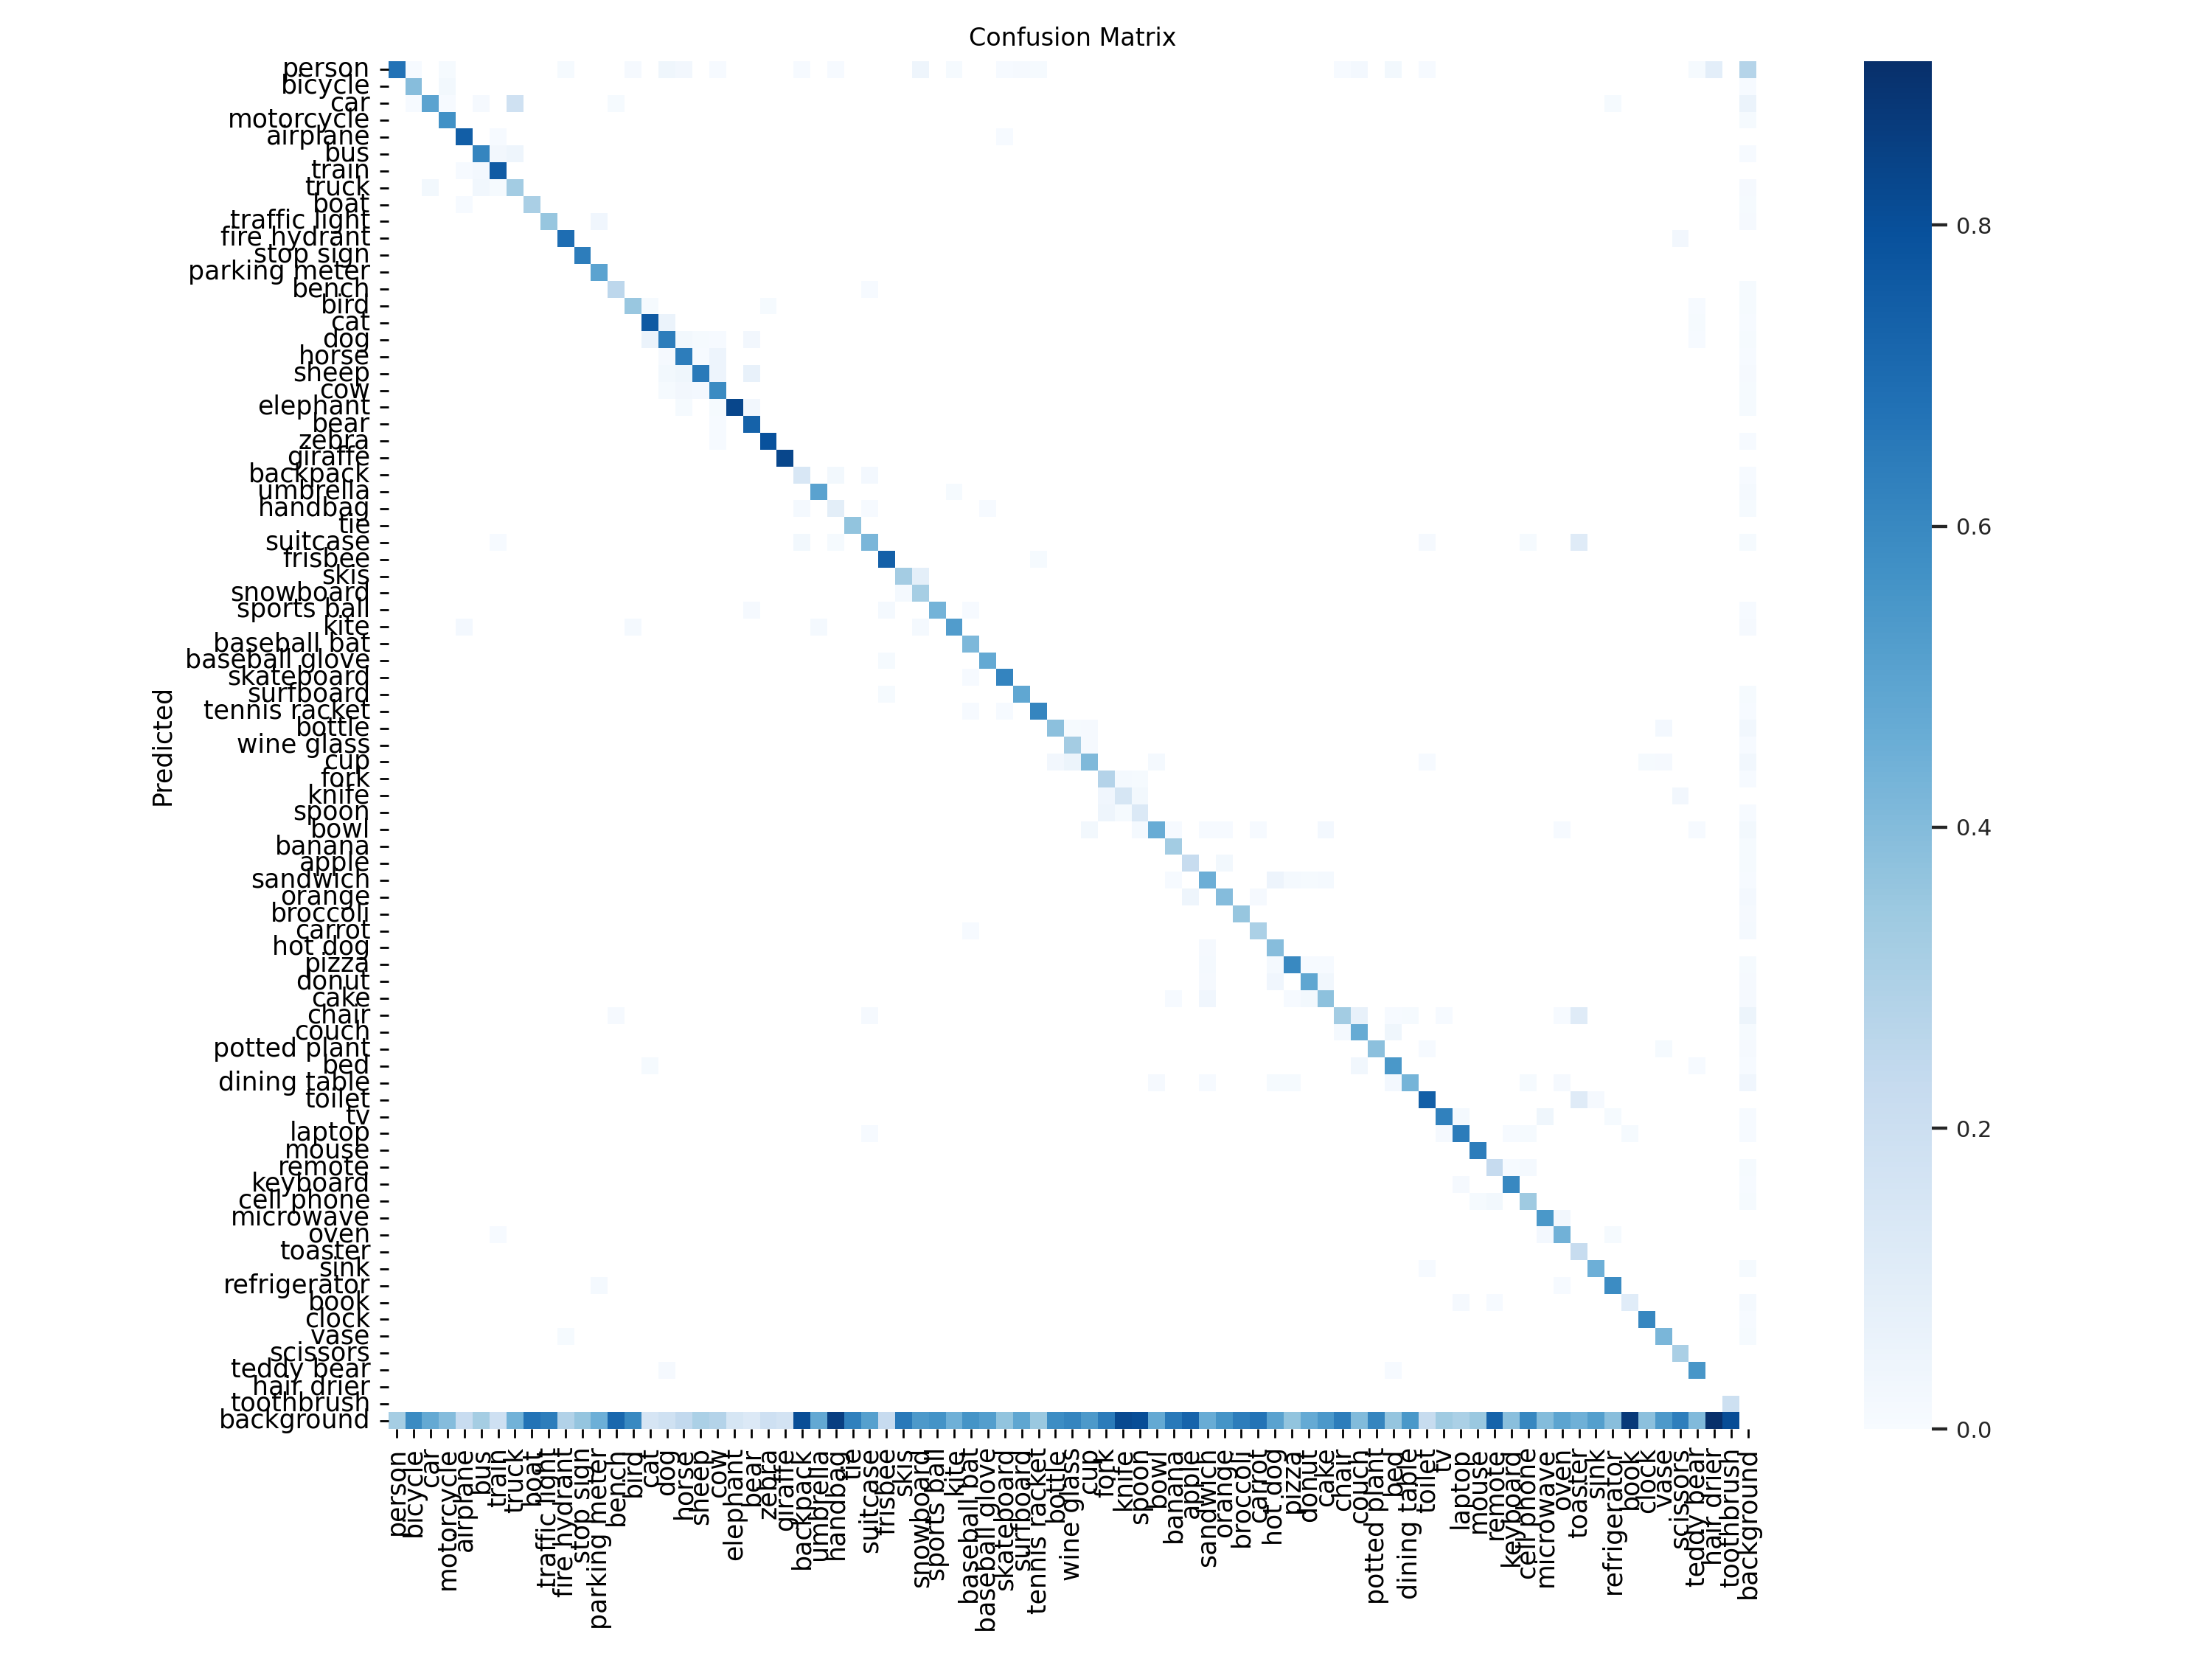

In [34]:
print("FP32 confusion matrix")
display_image(model_path.parent / "confusion_matrix.png", width=600, height=600)

INT8 confusion matrix


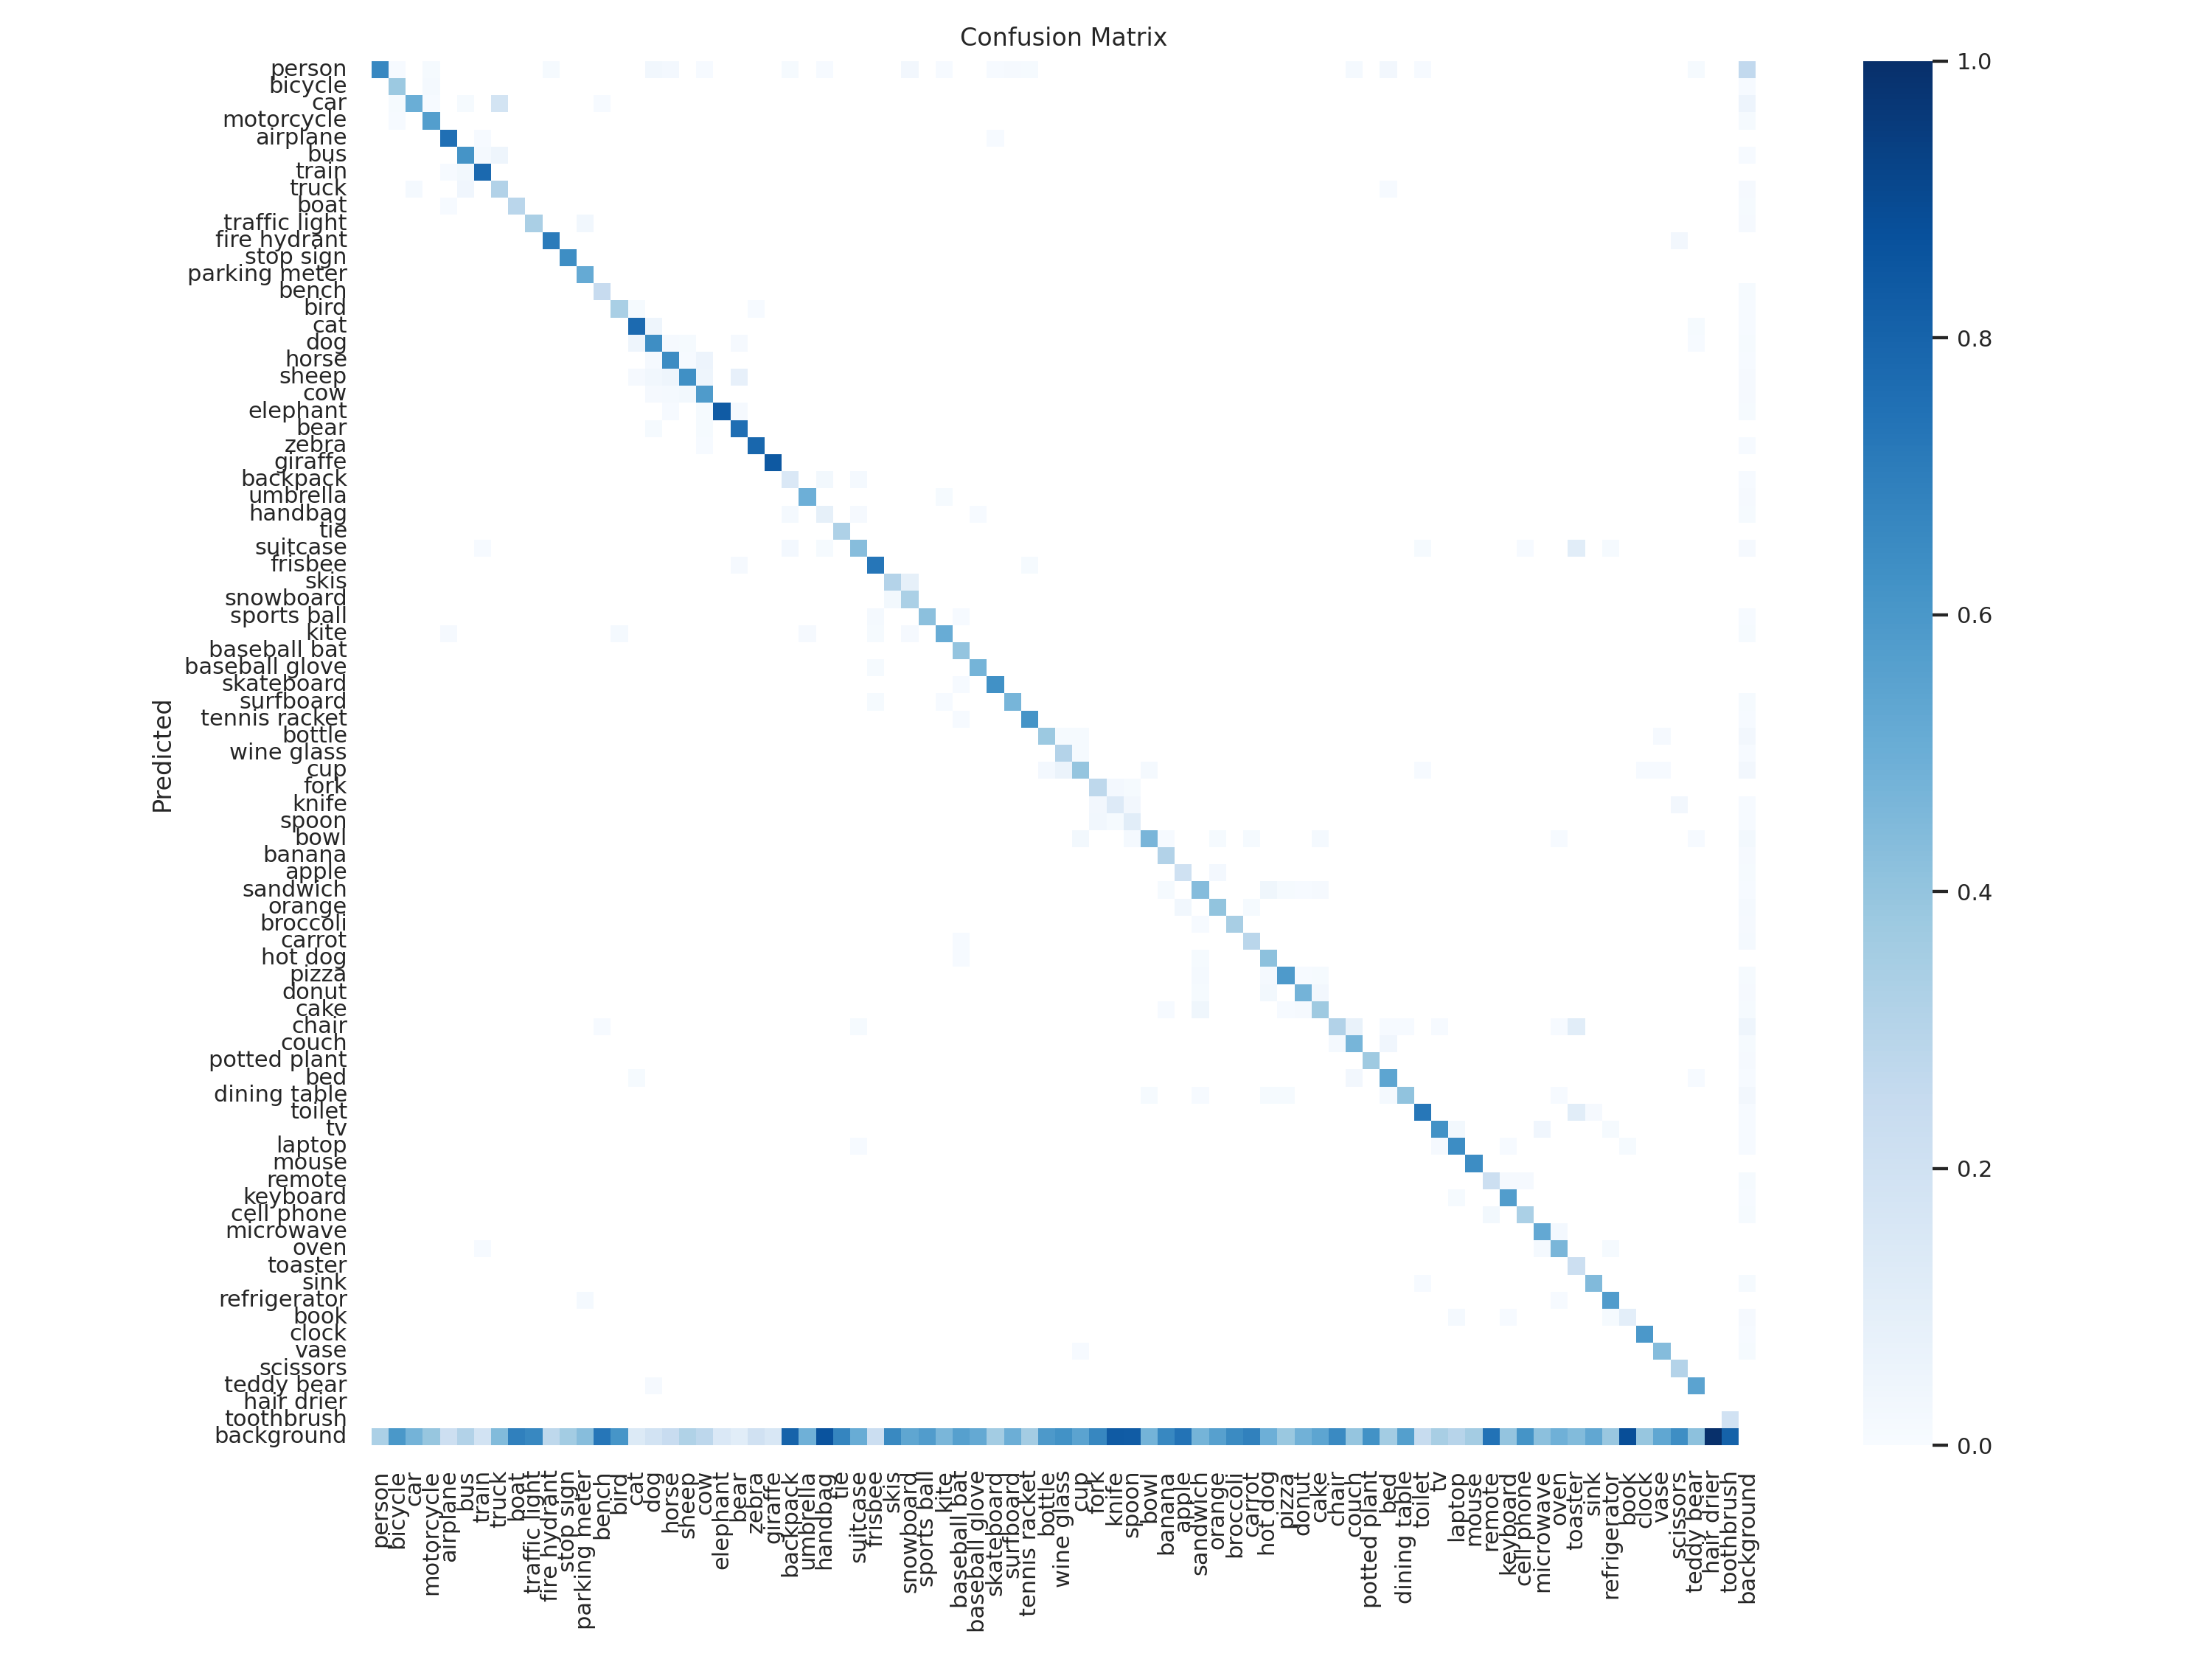

In [35]:
print("INT8 confusion matrix")
display_image(int8_model_path.parent / "confusion_matrix.png", width=600, height=600)

## Compare Performance of the Original and Quantized Models
Finally, use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html) to measure the inference performance of the `FP32` and `INT8` models.

> NOTE: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m <model_path> -d CPU -shape "<input_shape>"` to benchmark async inference on CPU on specific input data shape for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [ ]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m $model_path -d CPU -api async -shape "[1,3,640,640]"

In [ ]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m $int8_model_path -d CPU -api async -shape "[1,3,640,640]"